In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)



Mounted at /content/gdrive/


##Upload the dataset and replace the path below

In [ ]:

!unzip /content/gdrive/MyDrive/Datasets/IAM_dataset/Data.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/words/h07/h07-071a/h07-071a-07-07.png  
  inflating: __MACOSX/Data/words/h07/h07-071a/._h07-071a-07-07.png  
  inflating: Data/words/h07/h07-071a/h07-071a-05-02.png  
  inflating: __MACOSX/Data/words/h07/h07-071a/._h07-071a-05-02.png  
  inflating: Data/words/h07/h07-071a/h07-071a-05-03.png  
  inflating: __MACOSX/Data/words/h07/h07-071a/._h07-071a-05-03.png  
  inflating: Data/words/h07/h07-071a/h07-071a-07-06.png  
  inflating: __MACOSX/Data/words/h07/h07-071a/._h07-071a-07-06.png  
  inflating: Data/words/h07/h07-071a/h07-071a-09-03.png  
  inflating: __MACOSX/Data/words/h07/h07-071a/._h07-071a-09-03.png  
  inflating: Data/words/h07/h07-071a/h07-071a-09-01.png  
  inflating: __MACOSX/Data/words/h07/h07-071a/._h07-071a-09-01.png  
  inflating: Data/words/h07/h07-071a/h07-071a-07-04.png  
  inflating: __MACOSX/Data/words/h07/h07-071a/._h07-071a-07-04.png  
  inflating: Data/words/h07/h07-071a/h07-071a-05-01.png  
  

In [ ]:
import os
import numpy as np
import cv2
from glob import glob




In [ ]:
def load_and_preprocess_data(data_path):
    labels_path = os.path.join(data_path, 'labels', 'words.txt')
    words_path = os.path.join(data_path, 'words')

    with open(labels_path, 'r') as file:
        lines = file.readlines()

    samples = []
    img_path = []
    for line in lines:
        if line[0] == "#":
            continue
        parts = line.strip().split(' ')
        check = parts[1]
        if check != 'err':
          lab = parts[-1]
          folder1, rest = parts[0].split('-', 1) # Split once to separate the first folder name
          folder2 = rest.rsplit('-')[0]
          folder3 = rest.rsplit('-')[1] + '-'+ rest.rsplit('-')[2]  # Split once from the right to separate the second folder name and file name

          i_path = os.path.join(words_path, folder1, folder1 + '-' +folder2, folder1 + '-' +folder2+'-'+folder3+'.png')

          z = cv2.imread(i_path, cv2.IMREAD_GRAYSCALE)
          if z is not None :
              samples.append(lab)
              img_path.append(i_path)

          #print(img_path)

    return img_path, samples


In [ ]:
data_path = "/content/Data"
imgs_path ,samples = load_and_preprocess_data(data_path)

#X, y = zip(*samples)
#X = np.array(X).reshape(-1, 32, 128, 1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
print(len(imgs_path))
print(len(samples))

96454
96454


Gaitskell
(73, 382, 3)


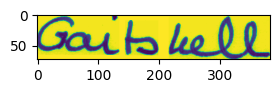

In [ ]:
import matplotlib.pyplot as plt

print(samples[5])

img = cv2.imread(imgs_path[5])
print(img.shape)

img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(3,3))
plt.imshow(img)

In [ ]:
characters = []
max_len =0
for words in samples:
  for c in [*words]:
    characters.append(c)
    max_len = max(max_len, len([*words]))
  #print(words)

unique = list(set(characters))
print("Max lenght of a word :", max_len)
print("Size of characters:", len(unique))

#labels
samples[:10]


Max lenght of a word : 21
Size of characters: 78


['A',
 'MOVE',
 'to',
 'stop',
 'Mr.',
 'Gaitskell',
 'from',
 'nominating',
 'any',
 'more']

In [ ]:
len(samples)

96454

In [ ]:
!pip install tensorflow
import keras, tensorflow as tf


In [ ]:
image_width = 128
image_height = 128

images=[]

for i in imgs_path:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    if img is not None :
      img = cv2.resize(img, (128, 128))
      img = img.astype("float32") / 255.0
      images.append(img)
      #samples.append([img, parts[-1]])



In [ ]:
len(images)

96454

In [ ]:
len(imgs_path)

96454

In [ ]:
len(characters)

402259

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

padding_token=99
all_labels_padded=[]
# Create a Tokenizer instance
tokenizer = Tokenizer(char_level=True, oov_token=None)

# Fit the Tokenizer on the characters
tokenizer.fit_on_texts(characters)

print(samples[0])
print(len(samples))
# Convert label to a sequence of integers
for item in samples:
  label_seq = tokenizer.texts_to_sequences([item])

  #print(label_seq)

  # Pad the sequence
  label_padded = pad_sequences(label_seq, maxlen=max_len, padding='post', value=padding_token)
  all_labels_padded.append(label_padded)


A
96454


In [ ]:
import numpy as np

re_images = np.array(images)
re_images = np.expand_dims(re_images, axis=-1)  # Add a channel dimension
re_all_labels_padded = np.squeeze(np.array(all_labels_padded), axis=1)  # Remove the unnecessary dimension




In [ ]:
from sklearn.model_selection import train_test_split

batch_size = 64

X_train, X_val, y_train, y_val = train_test_split(re_images, re_all_labels_padded, test_size=0.2, random_state=42)

# Convert to tensors
ten_X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
ten_X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)

ten_Y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
ten_Y_val = tf.convert_to_tensor(y_val, dtype=tf.int32)

train_dataset = tf.data.Dataset.from_tensor_slices((ten_X_train, ten_Y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((ten_X_val, ten_Y_val)).batch(batch_size)



In [ ]:
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    # Define the mask for valid labels (1) and padding labels (0)
    mask = tf.cast(tf.not_equal(y_true, 99), tf.float32)

    # Replace padding labels with a valid label value
    y_true = tf.where(tf.equal(y_true, 99), tf.zeros_like(y_true), y_true)

    # Calculate the sparse categorical crossentropy loss
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    # Apply the mask to the loss
    masked_loss = loss * mask

    # Calculate the mean loss over the non-zero values in the mask
    return tf.reduce_sum(masked_loss) / tf.reduce_sum(mask)

def masked_accuracy(y_true, y_pred):
    # Define the mask for valid labels (1) and padding labels (0)
    mask = tf.cast(tf.not_equal(y_true, 99), tf.float32)

    # Get the predicted class labels
    y_pred_labels = tf.argmax(y_pred, axis=-1, output_type=tf.int32)

    # Calculate whether the predictions are correct
    correct_preds = tf.equal(y_true, tf.cast(y_pred_labels, y_true.dtype))

    # Convert the boolean tensor to float
    correct_preds_float = tf.cast(correct_preds, tf.float32)

    # Apply the mask to the correct predictions tensor
    masked_correct_preds = correct_preds_float * mask

    # Calculate the accuracy over the non-zero values in the mask
    return tf.reduce_sum(masked_correct_preds) / tf.reduce_sum(mask)



In [ ]:
from keras.layers.activation.leaky_relu import LeakyReLU
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf


def create_model(input_shape, num_classes, max_len):
    inputs = Input(shape=input_shape)

    # Convolutional layers
    x = Conv2D(64, (3, 3), padding='same', name='conv1')(inputs)
    x = LeakyReLU(alpha = 0.1, name = 'leaky_relu1')(x)
    x = MaxPooling2D(pool_size=(3, 1), strides=(3, 1), name='pool1')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv2')(x)
    x = LeakyReLU(alpha = 0.1, name = 'leaky_relu2')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool2')(x)


    # Prepare above output for the LSTM layers
    new_shape = (max_len, x.shape[2] * x.shape[3])
    x = Reshape(target_shape=new_shape)(x)


    # LSTM layers
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)

    # Output layer
    x = Dense(num_classes+1, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)

    return model

# Create the model
input_shape = (image_height, image_width, 1)
num_classes = len(unique) + 1  # Add 1 for the padding token
model = create_model(input_shape, num_classes, max_len)



# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=masked_sparse_categorical_crossentropy, metrics=[masked_accuracy])

# Model summary
model.summary()


# Train the model
epochs = 5
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 64)      640       
                                                                 
 leaky_relu1 (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 pool1 (MaxPooling2D)        (None, 42, 128, 64)       0         
                                                                 
 conv2 (Conv2D)              (None, 42, 128, 128)      73856     
                                                                 
 leaky_relu2 (LeakyReLU)     (None, 42, 128, 128)      0         
                                                                 
 pool2 (MaxPooling2D)        (None, 21, 64, 128)       0   

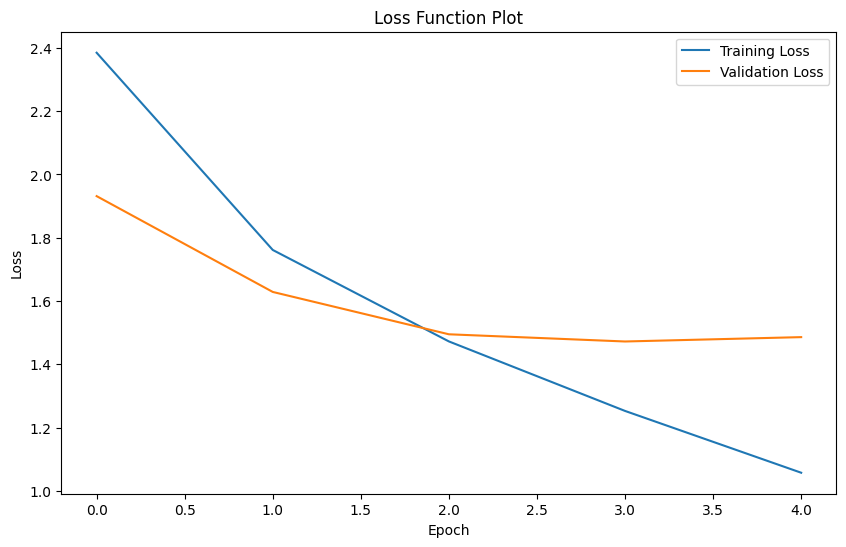

In [ ]:
# Extract the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history.get('val_loss')  # This might be None if you didn't use validation_split

# Create a plot to visualize the loss function
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
if val_loss is not None:
    plt.plot(val_loss, label='Validation Loss')

plt.title('Loss Function Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions using the model
predictions = model.predict(X_val)


603/603 [==============================] - 5s 6ms/step
